In [7]:
import os
import sys

current_dir = os.getcwd()
kit_dir = os.path.abspath(os.path.join(current_dir, ".."))
repo_dir = os.path.abspath(os.path.join(kit_dir, ".."))

sys.path.append(kit_dir)
sys.path.append(repo_dir)

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [8]:
import chromadb
import numpy as np
import io
import requests
import json
import shutil
import time
import yaml
from io import BytesIO
from PIL import Image
import pandas as pd
from pandas import DataFrame
from dotenv import load_dotenv
import tarfile
load_dotenv(os.path.join(repo_dir,".env"))

Python-dotenv could not parse statement starting at line 6


True

## Batch image ingestion

In [3]:
!snapi app list | grep CLIP -A 4

CLIP
Name                : CLIP
ID                  : 6c14325a-1be7-4e48-b38f-19b33745fc3b
Playground          : False
Prediction Input    : text



In [7]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = load_config(os.path.join(kit_dir,'config.yaml'))

PENDING_RDU_JOB_STATUS = 'PENDING_RDU'
SUCCESS_JOB_STATUS = 'EXIT_WITH_0'
FAILED_JOB_STATUS = 'FAILED'

In [8]:
class BatchClipProcessor():
    
    def __init__(self, config) -> None:
        self.headers = {
            'content-type': 'application/json',
            'key': os.getenv('SAMBASTUDIO_KEY'),
        }
        self.datasets_path = f".{config['clip']['datasets']['datasets_path']}"
        self.dataset_id = None
        self.dataset_name = config['clip']['datasets']['dataset_name']
        self.dataset_description = config['clip']['datasets']['dataset_description']
        self.dataset_source_type = config['clip']['datasets']['dataset_source_type']
        self.dataset_source_file = f".{config['clip']['datasets']['dataset_source_file']}"
        
        self.clip_app_id = config['clip']['apps']['clip_app_id']
        
        self.base_url = config['clip']['urls']['base_url']
        self.datasets_url = config['clip']['urls']['datasets_url'] 
        self.projects_url = config['clip']['urls']['projects_url'] 
        self.jobs_url = config['clip']['urls']['jobs_url'] 
        self.download_results_url = config['clip']['urls']['download_results_url'] 
    
        self.project_name = config['clip']['projects']['project_name']
        self.project_description = config['clip']['projects']['project_description']
        self.project_id=None
        
        self.job_name = config['clip']['jobs']['job_name']
        self.job_task = config['clip']['jobs']['job_task']
        self.job_type = config['clip']['jobs']['job_type']
        self.job_description = config['clip']['jobs']['job_description']
        self.model_checkpoint = config['clip']['jobs']['model_checkpoint']
        
        self.output_path = config['clip']['output']['output_path']
        
        
    def _get_call(self, url, params = None, success_message = None):
        response = requests.get(url, params=params, headers=self.headers)

        if response.status_code == 200:
            logging.info('GET request successful!')
            logging.info(success_message)
            logging.debug(f'Response: {response.text}')
        else:
            logging.error(f'GET request failed with status code: {response.status_code}')
            logging.error(f'Error message: {response.text}')
        return response

    def _post_call(self, url, params, success_message = None):
        response = requests.post(url, json=params, headers=self.headers)

        if response.status_code == 200:
            logging.info('POST request successful!')
            logging.info(success_message)
            logging.debug(f'Response: {response.text}')
        else:
            logging.error(f'POST request failed with status code: {response.status_code}')
            raise Exception(f'Error message: {response.text}')
        return response
    
    def _delete_call(self, url):
        response = requests.delete(url, headers=self.headers)    
        if response.status_code == 200:
            logging.info(f'Dataset {self.dataset_name} deleted successfully.')
            logging.debug(f'Response: {response.text}')
        else:
            logging.error(f'Failed to delete the resource. Status code: {response.status_code}')
            raise Exception(f'Error message: {response.text}')    
        return response
    def _generate_csv(self, dataset_dir):
        image_paths = []
        for root, dirs, files in os.walk(dataset_dir):
            for file in files:
                if file.endswith(('.jpg', '.jpeg', '.png', '.gif')):
                    image_path = os.path.relpath(os.path.join(root, file), dataset_dir)
                    image_paths.append(image_path)

        df = pd.DataFrame({'image_path': image_paths, 'description': '', 'subset': '', 'metadata': ''})
        df.to_csv(os.path.join(dataset_dir,'predictions.csv'), index=False)

    def _get_df_output(self, response_content: str) -> DataFrame:
        compressed_bytes = io.BytesIO(response_content)
        
        with tarfile.open(fileobj=compressed_bytes, mode="r:gz") as tar:
            output_tar_member = tar.getmember(self.output_path)
            output_file = tar.extractfile(output_tar_member)
            output_df = pd.read_json(io.BytesIO(output_file.read()), lines=True)       
        return output_df

    def search_dataset(self, dataset_name):
        url = self.base_url + self.datasets_url + '/search'
        params = {
            'dataset_name': dataset_name
        }
        response = self._get_call(url, params, f'Dataset {dataset_name} found in SambaStudio')
        parsed_reponse = json.loads(response.text)
        return parsed_reponse['data']['dataset_id']

    def delete_dataset(self, dataset_name):
        dataset_id = self.search_dataset(dataset_name)
        url = self.base_url + self.datasets_url + '/' + dataset_id
        response = self._delete_call(url)
        logging.info(response.text)
        
        
    def create_dataset(self, path):
        # create clip directory and source.json file
        
        dataset_name = f'{self.dataset_name}_{int(time.time())}'
            
        clip_directory = os.path.join(self.datasets_path, dataset_name)
        
        if not os.path.isdir(self.datasets_path):
            os.mkdir(self.datasets_path) 
            
        if not os.path.isdir(clip_directory):
            logging.info(f'Datasets path: {clip_directory} not found')
            
            source_file_data = {
                "source_path": clip_directory
            }
            
            with open(self.dataset_source_file, 'w') as json_file:
                json.dump(source_file_data, json_file)

        shutil.copytree(path, clip_directory)
        
        self._generate_csv(clip_directory)
        
        # create dataset
        command = f'echo yes | snapi dataset add \
            --dataset-name {dataset_name} \
            --job_type {self.job_type} \
            --apps {self.clip_app_id} \
            --source_type {self.dataset_source_type} \
            --source_file {self.dataset_source_file} \
            --description "{self.dataset_description}"'
        
        os.system(command)
        logging.info(f'Creating dataset: {dataset_name}')
        
        return dataset_name
         
    def check_dataset_creation_progress(self, dataset_name):
        url = self.base_url + self.datasets_url + '/' + dataset_name
        response = self._get_call(url)
        if response.json()["data"]["status"]=="Available": 
            return True
        else:
            return False
            
    def create_load_project(self):

        url = self.base_url + self.projects_url + '/' + self.project_name

        response = self._get_call(url, success_message=f'Project {self.project_name} found in SambaStudio')
        not_found_error_message = f"{self.project_name} not found"

        if not_found_error_message in response.text:
            
            logging.info(f'Project {self.project_name} wasn\'t found in SambaStudio')
            
            url = self.base_url + self.projects_url

            params = {
                'project_name': self.project_name,
                'description': self.project_description
            }

            response = self._post_call(url, params, success_message=f'Project {self.project_name} created!')

        parsed_reponse = json.loads(response.text)
        self.project_id = parsed_reponse['data']['project_id']
        return self.project_id
    
    def run_job(self, dataset_name):
        
        url = self.base_url + self.projects_url + self.jobs_url.format(project_id=self.project_id)
        
        params = {
            'task': self.job_task,
            'job_type': self.job_type,
            'job_name': f'{self.job_name}_{int(time.time())}',
            'project': self.project_id,
            'model_checkpoint': self.model_checkpoint,
            'description': self.job_description,
            'dataset': dataset_name,
        }

        response = self._post_call(url, params, success_message='Job running')
        parsed_reponse = json.loads(response.text)
        job_id = parsed_reponse['data']['job_id']
        
        return job_id
    
    def check_job_progress(self, job_id):
        """Check job progress of a given job.

        Args:
            job_id (str): The id of the job to check.
            
        Returns:
            bool: True when the job is finished.
        """

        url = self.base_url + self.projects_url + self.jobs_url.format(project_id=self.project_id) + '/' + job_id

        status = PENDING_RDU_JOB_STATUS
        while status != SUCCESS_JOB_STATUS:
            response = self._get_call(url, success_message='Still waiting for job to finish')
            parsed_reponse = json.loads(response.text)   
            status = parsed_reponse['data']['status']
            logging.info(f'Job status: {status}')
            if status == SUCCESS_JOB_STATUS:
                logging.info('Job finished!')
                break
            elif status == FAILED_JOB_STATUS:
                logging.info('Job failed!')
                return False
            time.sleep(10)
        
        return True  
    
    def delete_job(self, job_id):
        url = self.base_url +  self.projects_url + self.jobs_url.format(project_id=self.project_id) + '/' + job_id
        response = self._delete_call(url)
        logging.info(response.text)
        
    def retrieve_results(self, job_id):
        url = self.base_url + self.projects_url + self.jobs_url.format(project_id=self.project_id) + '/' + job_id + self.download_results_url
        response = self._get_call(url, success_message='Results downloaded!')
        df = self._get_df_output(response.content)
        return df

In [9]:
clip = BatchClipProcessor(config)

In [10]:
clip.create_load_project()

INFO:root:GET request successful!
INFO:root:Project image_search_project found in SambaStudio


'995e078d-c986-4fc9-b55c-133cf2664ac7'

In [11]:
dataset_name = clip.create_dataset(path=os.path.join(kit_dir,'data/images'))
while not clip.check_dataset_creation_progress(dataset_name):
    print("waiting for dataset available")
    time.sleep(1)

INFO:root:Datasets path: ../data/datasets/images_dataset_1717100251 dont 't found



Folder Information:
  - Number of Files: 181
  - Total Size: 63.55 MB

Are you sure you want to proceed? (yes/no)
: Uploading files


INFO:root:Creating dataset: images_dataset_1717100251


Dataset folder upload complete: ../data/datasets/images_dataset_1717100251
Dataset added successfully.
Time taken to upload the dataset: 209.640465259552 seconds


INFO:root:GET request successful!
INFO:root:None


In [12]:
clip.search_dataset(dataset_name)

INFO:root:GET request successful!
INFO:root:Dataset images_dataset_1717100251 found in SambaStudio


'd0d848e5-d45c-422e-81dc-0b4f884adb2a'

In [13]:
job_id = clip.run_job(dataset_name)

INFO:root:POST request successful!
INFO:root:Job running


In [14]:
result = clip.check_job_progress(job_id) 

INFO:root:GET request successful!
INFO:root:Still waiting for job to finish
INFO:root:Job status: PENDING_RDU
INFO:root:GET request successful!
INFO:root:Still waiting for job to finish
INFO:root:Job status: PENDING_RDU
INFO:root:GET request successful!
INFO:root:Still waiting for job to finish
INFO:root:Job status: PENDING_RDU
INFO:root:GET request successful!
INFO:root:Still waiting for job to finish
INFO:root:Job status: EXIT_WITH_0
INFO:root:Job finished!


In [15]:
df=clip.retrieve_results(job_id)

INFO:root:GET request successful!
INFO:root:Results downloaded!


In [16]:
clip.delete_job(job_id)

INFO:root:Dataset images_dataset deleted successfully.
INFO:root:{}


In [17]:
clip.delete_dataset(dataset_name)

INFO:root:GET request successful!
INFO:root:Dataset images_dataset_1717100251 found in SambaStudio
INFO:root:Dataset images_dataset deleted successfully.
INFO:root:{"detail":"The Dataset: d0d848e5-d45c-422e-81dc-0b4f884adb2a was successfully marked for deletion from the Dataset Hub."}


In [18]:
df.head()

predictions  \
0  {'image_vec': [-0.037841796875, -0.02770996093...   
1  {'image_vec': [0.0157470703125, 0.22265625, 0....   
2  {'image_vec': [-0.01336669921875, 0.046875, -0...   
3  {'image_vec': [0.01708984375, -0.01806640625, ...   
4  {'image_vec': [0.02392578125, 0.1689453125, 0....   

                     image_path  meta description  is_valid_image  \
0  technology/technology_19.png   NaN                        True   
1  technology/technology_18.png   NaN                        True   
2   technology/technology_9.png   NaN                        True   
3   technology/technology_8.png   NaN                        True   
4   technology/technology_5.png   NaN                        True   

   is_valid_text  
0          False  
1          False  
2          False  
3          False  
4          False

## Use inference endpoint

#### Send image

In [9]:
def embed_image(img_path= None, img=None):
    base_url = os.environ.get("BASE_URL")
    api_key = os.environ.get("API_KEY")
    project_id = os.environ.get("PROJECT_ID")
    endpoint_id = os.environ.get("ENDPOINT_ID") 
    url = f"{base_url}/api/predict/file/{project_id}/{endpoint_id}"
    if img_path:
        files = {'predict_file': open(img_path, 'rb')}
    elif img: 
        files = {'predict_file': img}
    else:
        raise Exception("please provide a image path or a bytes image file")
    headers = {'key': api_key}
    response = requests.post(url, files=files, headers=headers)
    return response.json()["data"][0]
    
jpg_file_path = os.path.join(kit_dir,"data/images/animals/animals_0.png")
print(embed_image(jpg_file_path))

[0.02294921875, 0.08837890625, -0.1591796875, -0.06982421875, 0.0306396484375, -0.0240478515625, 0.003448486328125, 0.01507568359375, -0.0224609375, 0.0113525390625, 0.04541015625, 0.059814453125, 0.02685546875, -0.031494140625, 0.03515625, 0.053466796875, -0.07373046875, 0.006317138671875, 0.00421142578125, -0.0184326171875, 0.0206298828125, 0.0308837890625, -0.01220703125, -0.021728515625, 0.006317138671875, -0.039794921875, 0.00014591217041015625, -0.007720947265625, 0.0211181640625, 0.0299072265625, -0.0198974609375, -0.0072021484375, 0.0005950927734375, -0.026123046875, -0.0380859375, -0.007080078125, -0.01507568359375, -0.01806640625, 0.05029296875, -0.037353515625, 0.0174560546875, -0.00897216796875, 0.0400390625, 0.0859375, -0.009765625, -0.053466796875, 0.0272216796875, -0.0247802734375, -0.03955078125, 0.0211181640625, -0.03466796875, 0.06689453125, 0.040283203125, -0.054931640625, -0.0247802734375, -0.02587890625, -0.037841796875, -0.007080078125, 0.056396484375, 0.037353515

#### Send Text

In [6]:
def embed_text(text):
    base_url = os.environ.get("BASE_URL")
    api_key = os.environ.get("API_KEY")
    project_id = os.environ.get("PROJECT_ID")
    endpoint_id = os.environ.get("ENDPOINT_ID") 
    url = f"{base_url}/api/predict/nlp/{project_id}/{endpoint_id}"
    input_data = {"inputs": [text]}
    headers = {'key': api_key, 'Content-Type': 'application/json'}
    response = requests.post(url, json=input_data, headers=headers)
    return response.json()["data"][0]
    
text = "lion in the jungle"
print(embed_text(text))


[0.00799560546875, 0.005218505859375, 0.0028839111328125, -0.02783203125, 0.057373046875, -0.0035247802734375, -0.00323486328125, 0.017822265625, 0.0201416015625, -0.0030670166015625, 0.0196533203125, 0.05126953125, -0.005126953125, 0.01611328125, -0.016845703125, -0.0419921875, -0.03955078125, -0.0108642578125, -0.054443359375, -0.015625, -0.0235595703125, -0.006103515625, 0.005035400390625, 0.0289306640625, 0.008056640625, 0.07470703125, 0.0029296875, 0.0111083984375, -0.02978515625, -0.050048828125, 0.0040283203125, 0.002593994140625, -0.01953125, 0.03564453125, 0.029052734375, 0.00604248046875, -0.0380859375, 0.0274658203125, -0.0150146484375, -0.03564453125, 0.012451171875, 0.031982421875, 0.02294921875, -0.035888671875, 0.045166015625, 0.068359375, -0.08837890625, -0.00164794921875, -0.05126953125, 0.052978515625, -0.0167236328125, -0.0181884765625, 0.0224609375, 0.0093994140625, -0.0771484375, -0.10107421875, -0.0791015625, 0.00897216796875, 0.0859375, 0.06787109375, -0.02648925

In [10]:

from chromadb.api.types import is_image, is_document, Images,  Documents, EmbeddingFunction, Embeddings, Protocol
from typing import cast, Union, TypeVar

## chromadb multimodal

In [11]:
Embeddable = Union[Documents, Images]
D = TypeVar("D", bound=Embeddable, contravariant=True)

class ClipEmbbeding(EmbeddingFunction[D]):
    def __init__(self) -> None:
        pass
    def __call__(self, input: D) -> Embeddings:
        embeddings: Embeddings = []
        for item in input:     
            if is_document(item):
                output = embed_text(item)
            elif is_image(item):
                image = Image.fromarray(item)
                buffer = io.BytesIO()
                image.save(buffer, format='PNG')
                output = embed_image(img=buffer.getvalue())
            embeddings.append(output)
        return cast(Embeddings, embeddings)


In [12]:
client = chromadb.PersistentClient(path=os.path.join(kit_dir, "data", "vector_db"))
clip_embedding=ClipEmbbeding()
try:
    client.delete_collection(name="image_collection")
except:
    pass
collection=client.get_or_create_collection(name="image_collection", embedding_function=clip_embedding, metadata={"hnsw:space": "l2"})
collection.get()


{'ids': [],
 'embeddings': None,
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

## Add individual images 

In [ ]:
def get_images(folder_path):
    images=[]
    paths=[]
    for root, _dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
                path=os.path.join(root, file)
                paths.append(path)
                image= np.array(Image.open(os.path.join(root, file)))
                images.append(image)
    return paths,images

In [ ]:
paths, images=get_images(os.path.join(kit_dir,"data/images"))
print(len(paths))

In [ ]:
collection.add(
    images=images,
    metadatas=[{"source": path} for path in paths],
    ids=paths,
    uris=paths
)

In [ ]:
collection.get()#include=["uris","documents"])

## Add batch preprocessed images

In [31]:
embeddings =  [element["image_vec"] for element in list(df["predictions"])] 
paths = list(df["image_path"].apply(lambda x: os.path.join(kit_dir,'data/images',x)))

In [34]:
collection.add(
    embeddings=embeddings,
    metadatas=[{"source": path} for path in paths],
    ids=paths,
    uris=paths
)

In [ ]:
collection.get()#include=["uris","documents"])

## Search methods

In [36]:
def search_image_by_text(query,n=3):
    result=collection.query(query_texts=[query],include=["uris", "distances"],n_results=n)
    return result['uris'][0], result["distances"][0]

In [37]:
def search_image_by_image(path,n=5):
    image= np.array(Image.open(path))
    result=collection.query(query_images=[image],include=["uris", "distances"],n_results=n)
    return result['uris'][0], result["distances"][0]

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images(image_paths, distances):
    num_images = len(image_paths)
    fig, axes = plt.subplots(1, num_images, figsize=(10*num_images, 10))
    
    for i, path in enumerate(image_paths):
        img = mpimg.imread(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}, d={distances[i]}')
    
    plt.show()


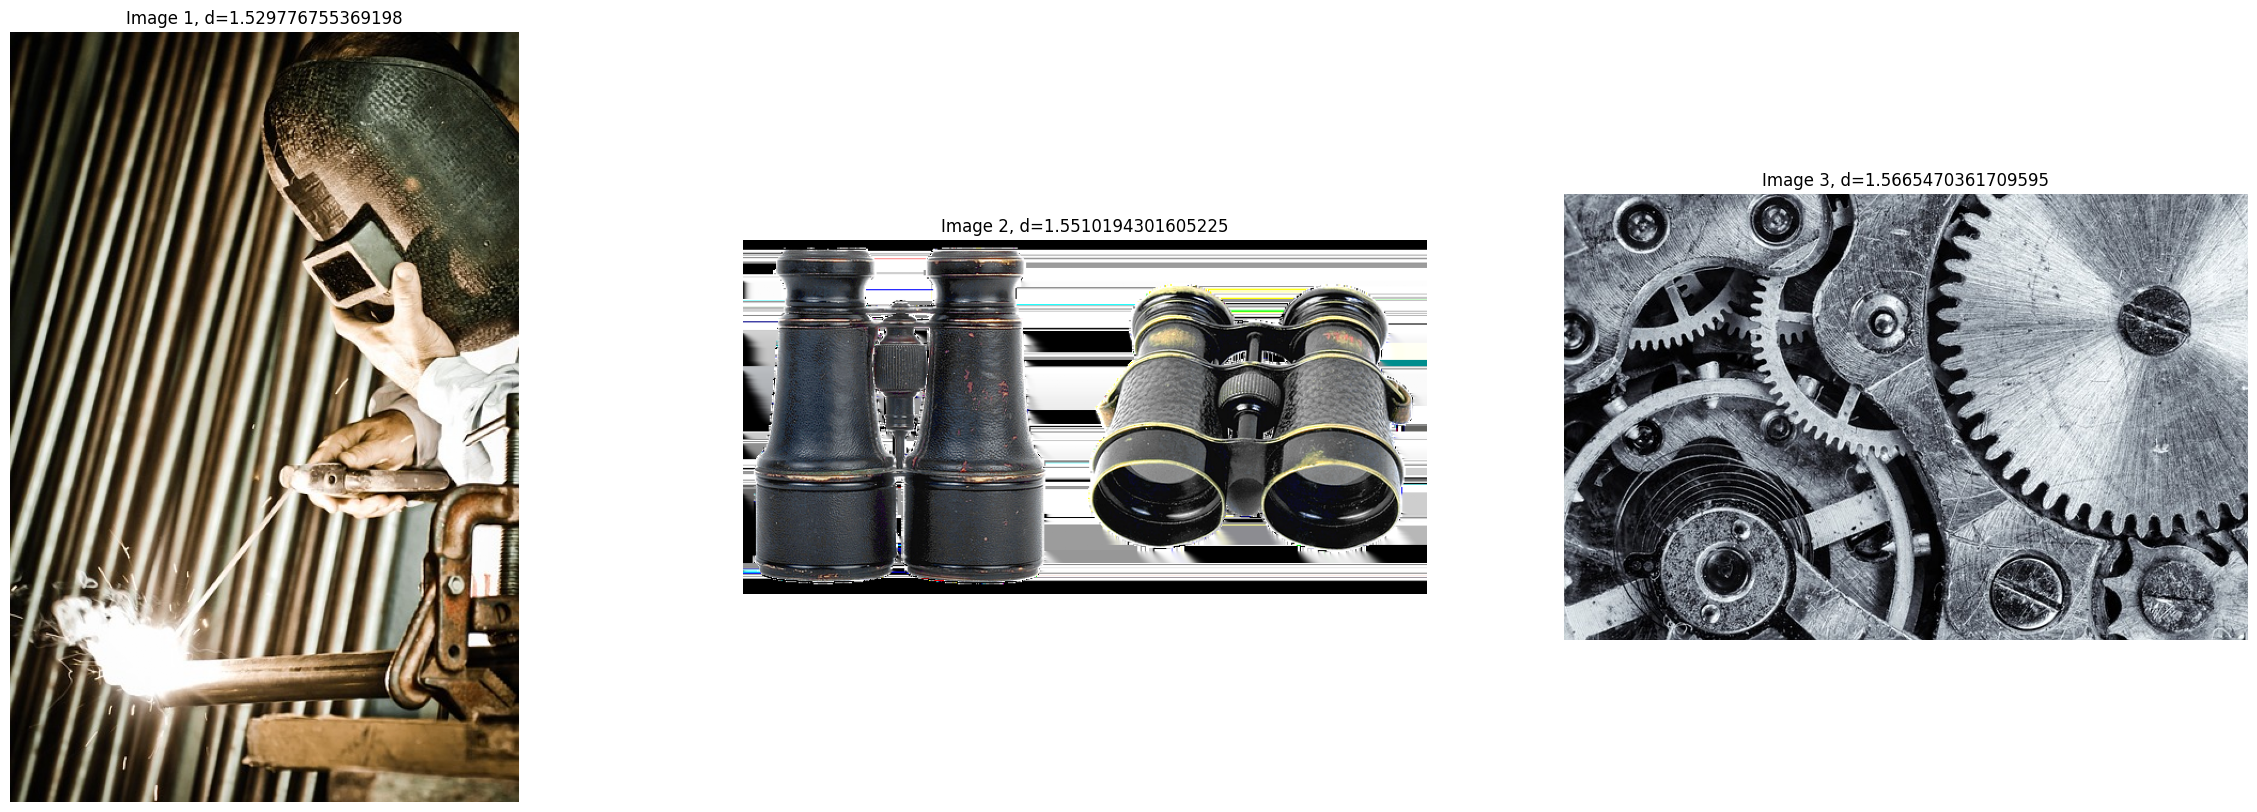

In [39]:
uris, distances = search_image_by_text("iron")
show_images(uris, distances)

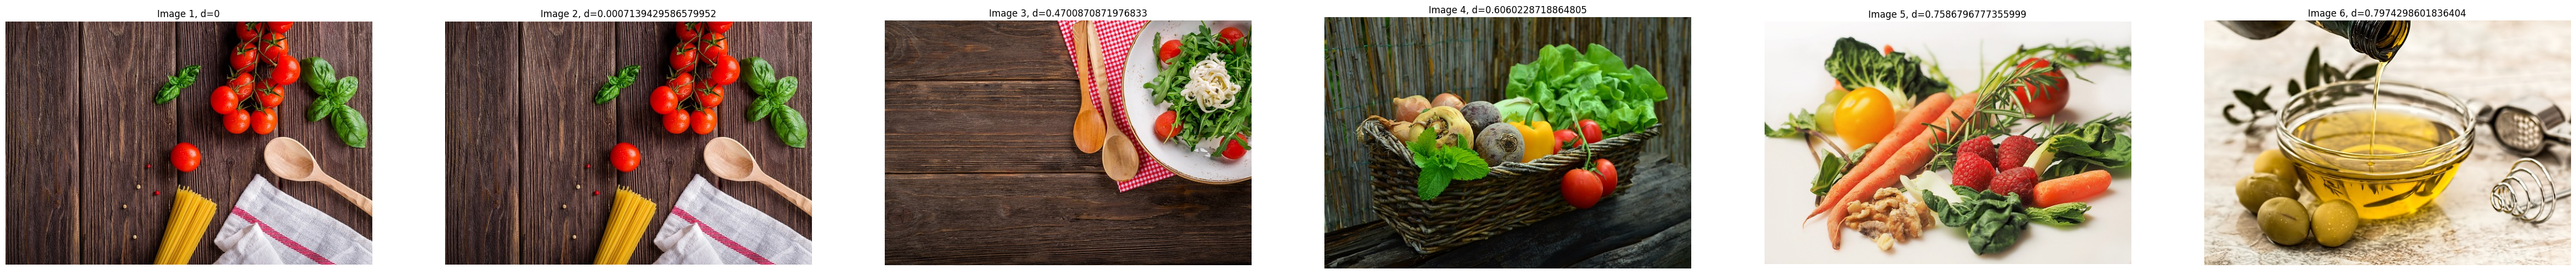

In [45]:
uris, distances = search_image_by_image("../sample.png")
uris.insert(0, "../sample.png")
distances.insert(0, 0)
show_images(uris, distances)